### Imports

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, shapiro, kstest

### Data (connecting with google drive)


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/A-B Data/cookie_cats.csv')



```
# This is formatted as code
```

### Exploratory Data Visualisation

In [ ]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
data.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


(array([9.0188e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,  4985.4,  9970.8, 14956.2, 19941.6, 24927. , 29912.4,
        34897.8, 39883.2, 44868.6, 49854. ]),
 <BarContainer object of 10 artists>)

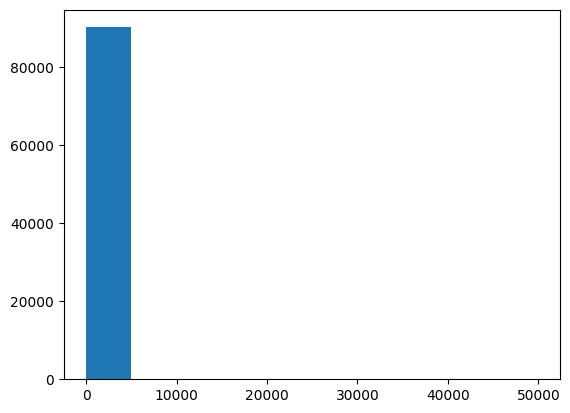

In [ ]:
plt.hist(data['sum_gamerounds'].values)

In [ ]:
data['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

<BarContainer object of 2 artists>

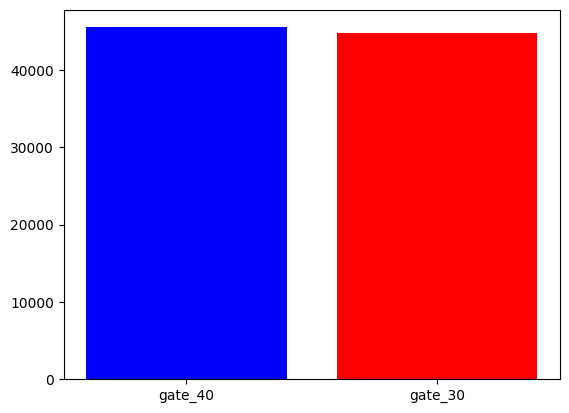

In [ ]:
plt.bar(x=['gate_40','gate_30'], height = data['version'].value_counts(), color = ['blue','red'])

### Removing outliers

In [ ]:
Q1 = data['sum_gamerounds'].quantile(0.25)
Q3 = data['sum_gamerounds'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['sum_gamerounds'] >=lower_bound) & (data['sum_gamerounds'] <= upper_bound)]

(array([37643., 15004.,  7967.,  5668.,  3968.,  2902.,  2206.,  1771.,
         1512.,  1371.]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <BarContainer object of 10 artists>)

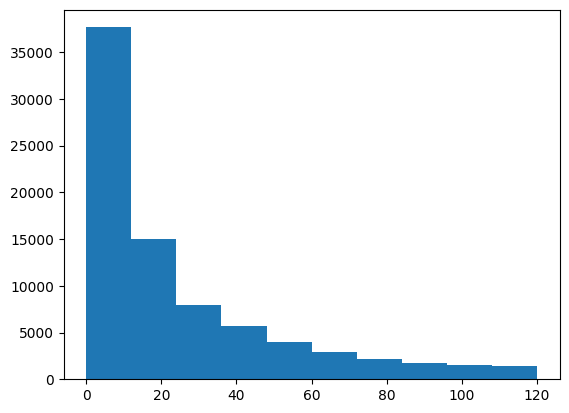

In [ ]:
plt.hist(data['sum_gamerounds'].values)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f760c9386d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f760c93bee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f760c93a0e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f760c93b760>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f760c93b250>],
 'means': []}

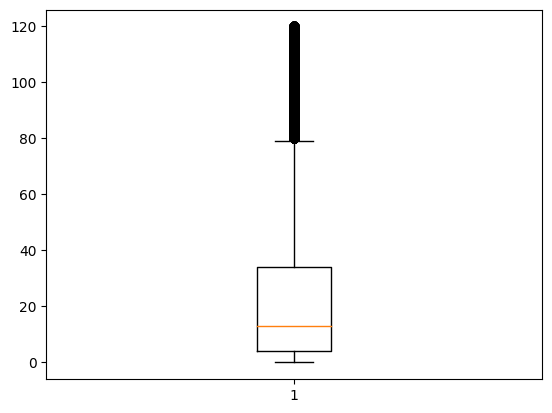

In [ ]:
plt.boxplot(data['sum_gamerounds'])

<Axes: xlabel='version'>

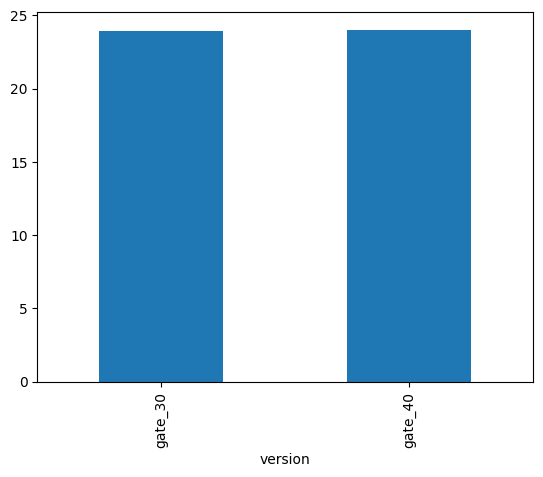

In [ ]:
data.groupby(data['version'])['sum_gamerounds'].mean().plot(kind = 'bar')

<Axes: >

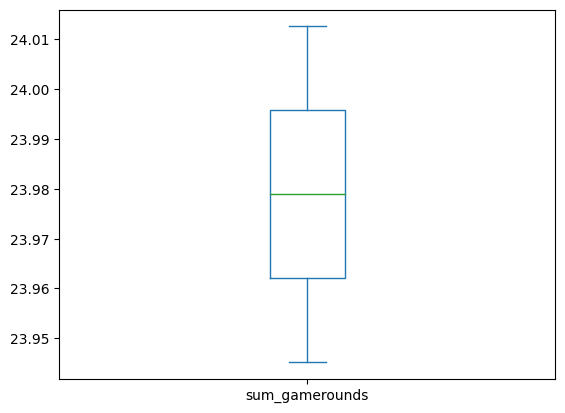

In [ ]:
data.groupby(data['version'])['sum_gamerounds'].mean().plot(kind = 'box')

### A/B Testing

Some people were randomly assigned gate_40 version of the game, while others were assigned gate_30 version. We will use A/B testing to see if that had any impact.
<br>
Hypothesis :<br>
H0 - Both groups are same.<br>
H1 - Both groups are different.

In [ ]:
grpA = data[data['version'] == 'gate_40']['sum_gamerounds']
grpB = data[data['version'] == 'gate_30']['sum_gamerounds']

In [ ]:
result = ttest_ind(grpA, grpB, equal_var = False)
print(result)

TtestResult(statistic=0.3468210518530167, pvalue=0.7287266726945116, df=80007.84322620952)


In [ ]:
if result[1] < 0.05:
  print("There is not a significant difference between the two population.")
else:
  print("There is a significant difference between the two population.")

There is a significant difference between the two population.


### Testing for normality

In [ ]:
grpA = data[data['version'] == 'gate_40']['sum_gamerounds']
grpB = data[data['version'] == 'gate_30']['sum_gamerounds']

### Shapiro test

In [ ]:
normal_A = shapiro(grpA)
normal_B = shapiro(grpB)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
normal_A

ShapiroResult(statistic=0.7920409440994263, pvalue=0.0)

In [ ]:
normal_B

ShapiroResult(statistic=0.8010086417198181, pvalue=0.0)

### K-S Test

In [ ]:
normal_A = kstest(grpA, stats.norm.cdf)
normal_A

KstestResult(statistic=0.857222127426666, pvalue=0.0, statistic_location=2, statistic_sign=-1)

In [ ]:
normal_B = kstest(grpB, stats.norm.cdf)
normal_B

KstestResult(statistic=0.8590299780472797, pvalue=0.0, statistic_location=2, statistic_sign=-1)

## Homogenity Test

Since, both the groups are not normally distributed, we go ahead with the homogenity test. We will be using levene's test to check for homogenity of variances.


In [ ]:
results = stats.levene(grpA, grpB)
results

LeveneResult(statistic=2.4066151181530264, pvalue=0.12082732122564133)

Since, p value is greater than 0.05, we conclude that both the populations have same variances. Since, variances are homogeneous, we will perform any non parameteric test. For this case, we are choosing Man-Whitney U test.

### Man-Whitney U test



* H0 (Null hypothesis) - There is no significant difference
* H1 (Alternate hypothesis) - There is significant difference




In [ ]:
results = stats.mannwhitneyu(grpA, grpB)
results

MannwhitneyuResult(statistic=793428154.0, pvalue=0.03885510150342266)

Since the p-value is less than 0.05, we conclude that there is significant difference between control and experimental groups.
Hence A/B groups are not similar.